[캐글](https://www.kaggle.com/amyjang/tensorflow-pneumonia-classification-on-x-rays)을 기반으로 작성된 실습예제이다.

데이터셋은 이번 노드에서 사용할 데이터는 캐글의 Chest X-Ray Images 이다. \
해당 이미지는 중국 광저우에 있는 광저우 여성 및 어린이 병원의 1~5 세 소아 환자의 흉부 X선 영상이다. 

- [폐렴이란?](https://ko.wikipedia.org/wiki/폐렴) \
폐에 염증이 생기는 것이다.
- [염증이란?](https://ko.wikipedia.org/wiki/염증) \
염증은 쉽게 말해 우리 몸을 지키기 위해 백혈구들이 싸우고 있는 장소라고 할 수 있다. \
폐렴이라면 폐에서 바이러스나 세균으로부터 우리 몸을 지키기 위해 백혈구들이 싸우고 있는 상황.

### 폐렴 구별법
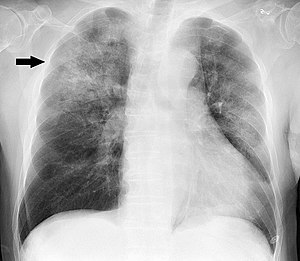
X-RAY 사진상, 다양한 양상의 음영(폐 부위에 희미한 그림자) 증거가 관찰되지만, 실제로 영상을 보면 희미한 경우가 많이 있어 저게 실제로 폐렴으로 인한 것인지 아니면 다른 이유 때문인지 파악이 힘들다.

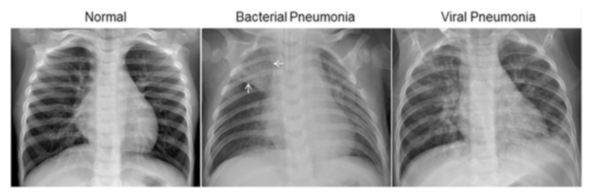
- 정상적인 흉부 X-RAY(왼쪽)는 이미지에서 비정상적인 음영 영역이 없는 깨끗한 폐
- 세균성 폐렴 (가운데)은 일반적으로 오른쪽 상부 엽 (흰색 화살표)에 있는 나타낸다.
- 바이러스성 폐렴 (오른쪽)은 양쪽 폐에서보다 확산된 "interstitial(조직 사이에 있는)" 패턴으로 나타난다.

# 1. Set-up

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

앞으로 필요한 변수들을 생성한다.

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보자.
BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


# 2. 데이터 가져오기
데이터를 열어보면 이미 train, val(validation), test 로 나누어져 있다.

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


- train 안에는 5216개, 89%
- test 안에는 624개, 10.7%
- val 안에는 16개가 있다. 0.3%

val 개수가 너무 없기 때문에 train에서 val에 쓰일 데이터를 더 가져와보자.

train과 val에 있는 데이터를 모은 다음에 train : val를 80:20으로 분할한다.

In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담는다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눈다
train_size = math.floor(len(filenames)*0.8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


train 데이터 안에 정상 이미지 수와 폐렴 이미지 수를 살펴보자.

In [5]:
# 정상 이미지와 폐렴 이미지를 구분해야 하는데 다행히도 파일 경로에 힌트가 나와있다
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person665_virus_1250.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person621_virus_1194.jpeg


In [6]:
# 이제 파일 경로에 NORMAL이 있는지 확인하면 정상 이미지를 수를 알 수 있다.
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

# 파일 경로에 PNEUMONIA이 있는지 확인하면 폐렴 이미지도 수를 알 수 있다.
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1074
Pneumonia images count in training set: 3111


결과를 보면 정상보다 폐렴 이미지 수가 3배 더 많이 있다. \
우리가 사용할 CNN 모델의 경우 데이터가 클래스별 balance가 좋을수록 training을 잘 하지만, 데이터가 클래스 불균형(imbalance)한 것은 차후에 조정할 예정이다. test와 val 데이터셋은 평가하기 위해서 사용되기 때문에 학습과 관련이 없으므로 imbalance한 데이터 셋이어도 문제없다.

`tf.data` 인스턴스를 만들어 보자. `tf.data`는 tensorflow에서 학습시킬 때, 배치처리 작업을 보다 효율적으로 할 수 있도록 해준다.

[tf.tensor](https://hwiyong.tistory.com/329)

In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

Train 데이터셋, validation 데이터셋 개수 확인해보자.

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


현재 이미지에는 라벨 데이터가 따로 없다. \
파일 경로에 'NORMAL'이나 'PNEUMONIA'가 포함되어 있기 때문에 이를 이용해서 라벨 데이터를 만들어 주는 함수를 만들어보자.

In [9]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

이미지 데이터는 현실적으로 사이즈가 제각각일 가능성이 높으므로, 이미지의 사이즈를 통일 시키고 GPU 메모리를 더욱 효율적으로 사용하기 위해 이미지 사이즈를 줄여보자. \
`decode_img` 함수와 `process_path` 함수를 만들겠습니다.

`process_path` 함수에서 `decode_img` 함수를 이용해서 이미지의 데이터 타입을 float으로 바꾸고 사이즈를 변경하자. \
`get_label`을 이용해서 라벨 값을 가져오자.

In [10]:
# 이미지를 알맞은 형식으로 바꾼다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어온다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

train 데이터 셋과 validation 데이터 셋을 만듭니다. \
num_parallel_calls 파라미터에서 set-up에서 초기화 한 AUTOTUNE을 이용하면 더욱 빠르게 데이터를 처리해 준다.

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

이미지가 잘 리사이즈 되었는지, 그리고 라벨이 잘 들어가 있는지 확인해보자.

In [12]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


사이즈가 잘 변환되어 있고 라벨도 잘 들어가 있는 것이 확인되었다. \
참고로, 코드에서 `train_ds.take(1)`은 하나의 데이터만 가져온다는 의미이다.

위에서 train과 validation 데이터셋을 만든 것처럼 test 데이터셋도 만들어 보자. \
그리고 데이터 개수도 확인해보자.

In [13]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


`prepare_for_training()` 함수는 학습 데이터를 효율적으로 할 수 있도록 데이터를 변환 시켜준다.
- `shuffle()`을 사용하며 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택한다.

- `repeat()`를 사용하면 epoch를 진행하면서 여러 번 데이터셋을 불러오게 되는데, 이때 repeat()를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용할 수 있게 해준다. 예를 들어, 100개의 데이터를 10번 반복하면 1000개의 데이터가 필요하게 된다. repeat()를 사용하면 자동으로 데이터를 맞춰준다.

- `batch()`를 사용하면 BATCH_SIZE에서 정한 만큼의 배치로 주어진다.
예를 들어, 100개의 데이터를 10개의 배치로 나누게 되면 각 배치에는 10개의 데이터로 나뉘게 된다.

- `prefetch()`를 사용하면 학습 데이터를 나눠서 읽어오기 때문에, 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있다.

In [14]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

# 3. 데이터 시각화
데이터를 보기 위해 먼저, train에 있는 batch 중 첫 번째 배치를 추출한다. \
추출된 배치를 image와 label 데이터 셋으로 나눈다. \
이제 show_batch() 함수를 이용해서 결과 사진을 살펴보자.

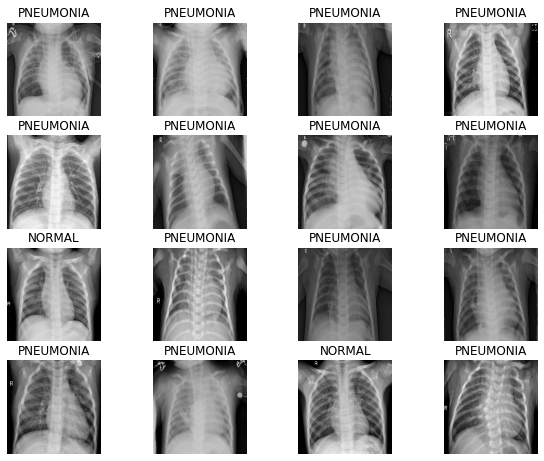

In [15]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여준다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

# 4. CNN 모델링
가장 대표적인 딥러닝 모델인 CNN을 모델링하고 결과를 만들어 보자.

[CNN, Convolutional Neural Network 요약](http://taewan.kim/post/cnn/)

먼저, Convolution block을 만든다. \
conv_block()의 구성은 
- Convolution을 두 번 진행하고, 
- Batch Normalization을 통해서 Gradient vanishing, Gradient Exploding을 해결한다. 
- 그리고 Max Pooling을 한다.

In [16]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [17]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

모델에는 Batch Normalization과 Dropout이라는 두 가지 regularization 기법이 동시에 사용되고 있으며, \
일반적으로 이런 방법은 잘 사용되지 않거나, **금기시**되기도 한다. 

대표적으로 아래와 같은 논문의 사례를 있다. \
[Understanding the Disharmony between Dropout and Batch Normalization by
Variance Shift](https://openaccess.thecvf.com/content_CVPR_2019/papers/Li_Understanding_the_Disharmony_Between_Dropout_and_Batch_Normalization_by_Variance_CVPR_2019_paper.pdf) \
위 논문에서는 variance shift를 억제하는 Batch Normalization과 이를 유발하는 Dropout을 동시에 사용하는 것이 어울리지 않는다고 주장하고 있다.

그러나, 실용적으로는 두 방법을 같이 쓰는 것이 낫다고 보는 견해도 없는 것은 아니다. \
예외적으로 동시에 사용하는 것이 성능 향상에 도움을 주는 경우가 실제로 있으며, 아래 논문과 같이 두 방법을 같이 쓰는 것을 옹호하는 경우도 있다.

[Rethinking the Usage of Batch Normalization and Dropout in the Training of
Deep Neural Networks](https://arxiv.org/pdf/1905.05928.pdf)

In [18]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

# 5. 데이터 imbalance 처리
위에서 얘기했던 데이터 imbalance 문제이다.
'Normal'과 폐렴에서 'Pneumonia' 중에 'Pneumonia' 데이터가 많이 있었으며, 이렇게 한 라벨이 너무 많은 경우를 imbalance 하다고 하는데, \
데이터를 학습할 때 imbalance한 데이터의 경우 학습 효과가 좋지 않을 수 있다.

이런 문제들을 해결하는 방법으로 Weight balancing이라는 테크닉이 사용되며, Weight balancing 은 training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법이다. \
Keras는 model.fit()을 호출할 때 파라미터로 넘기는 class_weight 에 이러한 클래스별 가중치를 세팅할 수 있도록 지원하고 있다. \
상세한 내용은 아래 링크를 참고하자.

[딥러닝에서 클래스 불균형을 다루는 방법](https://3months.tistory.com/414)

아래 코드에서 
- `weight_for_0`은 'Normal' 이미지에 사용할 weight를, 
- `weight_for_1`은 'Pneumonia' 이미지에 사용할 weight를 세팅한다. 

이 weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정한다.



In [19]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


# 6. 모델 훈련
이미지 훈련은 GPU를 사용할 것이기 때문에 먼저 GPU를 선택한다. \
모델은 위에서 만들었던 모델 함수인 `build_model()`을 model에 선언한다.

- 이미지의 라벨이 두 개밖에 없기 때문에 "binary_cross entropy" loss를 사용하며, optimizer로 'adam'을 한다. 
- 성과에 대해서 측정하기 위한 metrics으로 'accuracy', 'precision', 'recall'을 사용한다.

In [20]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

모델을 fit 해보자. 
각 파라미터에 위에서 선언했었던 변수, 데이터 셋을 가져와서 각각에 넣어준다.

In [21]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 96s 254ms/step - loss: 0.5545 - accuracy: 0.7090 - precision: 0.9178 - recall: 0.6728 - val_loss: 0.6004 - val_accuracy: 0.7375 - val_precision: 0.7375 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 64s 244ms/step - loss: 0.2494 - accuracy: 0.8973 - precision: 0.9671 - recall: 0.8926 - val_loss: 1.4842 - val_accuracy: 0.7375 - val_precision: 0.7375 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 64s 246ms/step - loss: 0.1944 - accuracy: 0.9192 - precision: 0.9799 - recall: 0.9114 - val_loss: 0.1896 - val_accuracy: 0.9221 - val_precision: 0.9086 - val_recall: 0.9948
Epoch 4/25
261/261 [==============================] - 63s 240ms/step - loss: 0.1640 - accuracy: 0.9394 - precision: 0.9820 - recall: 0.9365 - val_loss: 0.5832 - val_accuracy: 0.7923 - val_precision: 0.7808 - val_recall: 0.9987
Epoch 5/25
261/261 [==============================] - 63s 243ms/step - loss: 0.1695 - accura

# 7. 결과 확인

그래프로 Epochs 마다 모델의 precision, recall, accuracy, loss가 어떻게 변하는지 확인해보자.

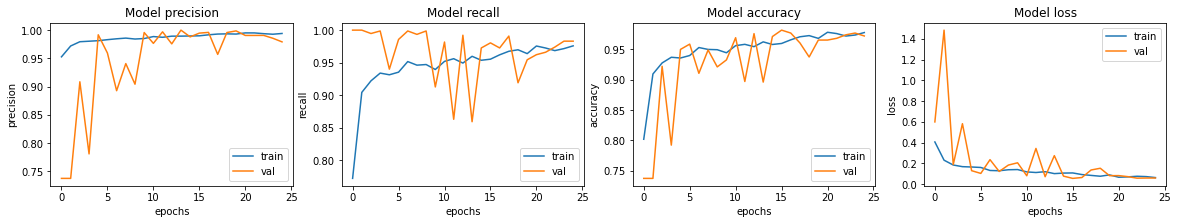

In [22]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

테스트 데이터로 모델 평가를 해보자.

모델 평가를 위해 loss, accuracy, precision, recall 값을 출력해보자.

In [23]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 70ms/step - loss: 1.3935 - accuracy: 0.7596 - precision: 0.7230 - recall: 0.9974
Loss: 1.3935343027114868,
Accuracy: 0.7596153616905212,
Precision: 0.7230483293533325,
Recall: 0.9974358677864075


페렴 진단에 있어서 약 80% 정도는 맞출 수 있게 되었지만, \
의사분들이 90% 이상이시니 거의 비슷한 실력이라기에는 다소 모자라는 느낌은 있지만, 의료 보조 용도로는 어느 정도 쓸만한 모델이다.

그럼 성능을 좀 더 개선해볼 수 있는 방법은 없을까? 라는 고민이 생긴다. \
오늘 우리가 다룬 폐렴 데이터를 기반으로 한 연구도 많이 찾아볼 수 있다.

의료 데이터의 경우 구하기도 어렵고 구하더라도 데이터가 작은 경우가 더러 있다. \
이런 문제를 해결하기 위해 Data augmentation 방법을 많이 시도를 많이하며, Data augmentation 은 각 데이터에 최적화된 방법을 찾기가 어렵고 제약사항이 많다. \
그래서 의료분야에서는 기본적인 Data augmentation 방법들을 많이 사용한다. \
이미지 회전, 가우시안 노이즈 추가 방법 등을 많이 사용하며, 특히 장기의 크기는 사람마다 거의 바뀌지 않으므로, 이런 특성을 이용한 방법이 노이즈 추가 방법이다.

전통적인 Data augmentation 방법 이외에도 GAN을 이용해서 Data augmentation을 시도하는 연구들도 많이 있으니 참고해보자.